In [2]:
!git clone https://github.com/giorgiodemarchi/Brain-Tumor-Detection-CNN-vs-ViT.git

Cloning into 'Brain-Tumor-Detection-CNN-vs-ViT'...
remote: Enumerating objects: 4073, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 4073 (delta 2), reused 3 (delta 0), pack-reused 4064
Receiving objects: 100% (4073/4073), 92.68 MiB | 27.07 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (4604/4604), done.


# CNN

*   List item
*   List item



In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Brain-Tumor-Detection-CNN-vs-ViT/metadata_rgb_only.csv', index_col=0)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"


Load data:

In [5]:
def load_image(image_path):
    with Image.open(image_path) as img:
        return img.copy()

df = df.iloc[:-1]  # Drop last row

df['image_data'] = None # Initialize column

# Read image data
for i, row in df.iterrows():
  label = row['class']
  path = row['image']

  if label == 'tumor':
      image_path = "Brain-Tumor-Detection-CNN-vs-ViT/Brain Tumor Data Set//Brain Tumor Data Set/Brain Tumor/" + path
  else:
      image_path = "Brain-Tumor-Detection-CNN-vs-ViT/Brain Tumor Data Set//Brain Tumor Data Set/Healthy/" + path

  df.loc[i, 'image_data'] = load_image(image_path)

<ipython-input-5-5029d9ec7fd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_data'] = None # Initialize column
<ipython-input-5-5029d9ec7fd4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'image_data'] = load_image(image_path)


In [6]:
df['class'].value_counts()

tumor     2421
normal    2039
Name: class, dtype: int64

See some examples

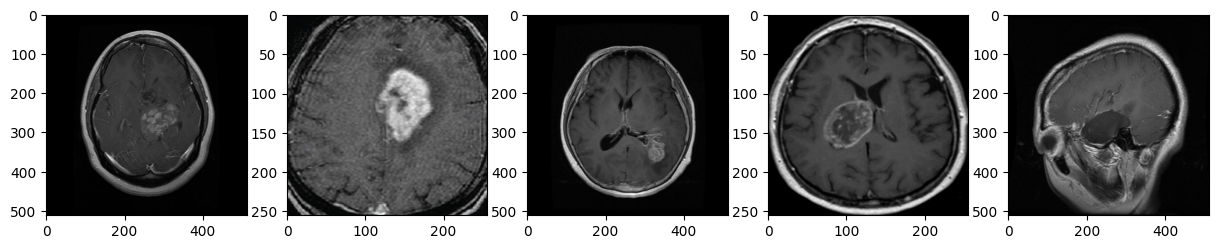

In [7]:
# Tumor examples

fig, ax = plt.subplots(1,5, figsize=(15,3))

for i in range(5):  # Loop through the first five entries
  img = df[df['class']=='tumor'].iloc[i]['image_data']  # Get the image object
  ax[i].imshow(img)

plt.show()

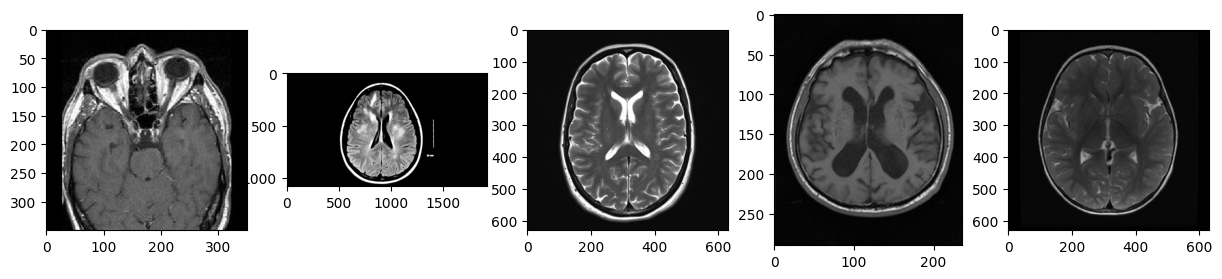

In [8]:
# Tumor examples

fig, ax = plt.subplots(1,5, figsize=(15,3))

for i in range(5):  # Loop through the first five entries
  img = df[df['class']=='normal'].iloc[i]['image_data']  # Get the image object
  ax[i].imshow(img)

**Data preprocessing**

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df['label'] = np.where(df['class']=='tumor', 1, 0)
df = df[['image_data', 'label']]
df

,image_data,label
0,<PIL.Image.Image image mode=RGB size=512x512 a...,1
2,<PIL.Image.Image image mode=RGB size=256x256 a...,1
3,<PIL.Image.Image image mode=RGB size=512x512 a...,1
4,<PIL.Image.Image image mode=RGB size=256x256 a...,1
5,<PIL.Image.Image image mode=RGB size=512x512 a...,1
...,...,...
4594,<PIL.Image.Image image mode=RGB size=173x201 a...,0
4595,<PIL.Image.Image image mode=RGB size=300x168 a...,0
4596,<PIL.Image.Image image mode=RGB size=452x509 a...,0
4597,<PIL.Image.Image image mode=RGB size=177x197 a...,0


In [11]:
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

print(len(test_df))
print(len(val_df))
print(len(train_df))

1338
625
2497


In [12]:
from torchvision import transforms

In [13]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),

        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(30),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),

    ]
)

In [14]:
import torch
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
  """
  Custom definition of image dataset
  """
  def __init__(self, dataframe, transform=None):
      self.dataframe = dataframe
      self.transform = transform

  def __len__(self):
      return len(self.dataframe)

  def __getitem__(self, idx):

      image = self.dataframe.iloc[idx]['image_data']
      label = self.dataframe.iloc[idx]['label']

      if self.transform:
          image = self.transform(image)

      return image, label

In [15]:
train_df = CustomImageDataset(dataframe=train_df, transform=transform)
val_df = CustomImageDataset(val_df, transform=transform)
test_df = CustomImageDataset(test_df, transform=test_transform)

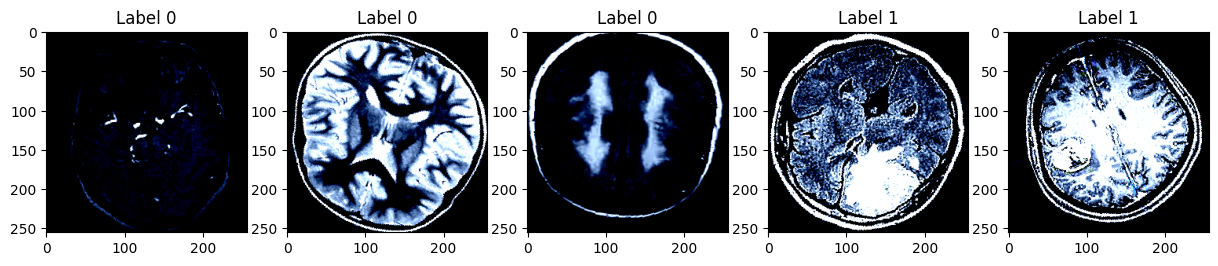

In [16]:
# Visualize transformed training images
fig, ax = plt.subplots(1,5, figsize=(15,3))

for i in range(5):
  image, label = train_df[i]

  img_np = image.numpy().transpose((1, 2, 0))   # Reshape because tensors have channel dimension first
  ax[i].imshow(img_np)
  ax[i].set_title(f"Label {label}")

plt.show()

**Data Loaders**

In [52]:
train_loader = torch.utils.data.DataLoader(train_df,
                                           batch_size = 64,
                                           shuffle = True,
                                           num_workers = 2)

val_loader = torch.utils.data.DataLoader(val_df,
                                         batch_size = 64,
                                         shuffle = True,
                                         num_workers = 2)

test_loader = torch.utils.data.DataLoader(test_df,
                                         batch_size = 64,
                                         shuffle = True,
                                         num_workers = 2)

In [18]:
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



**Define CNN**

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
def findConv2dOutShape(hin, win, conv, pool=2):
    """
    This function can be useful in determining the output size of a convolutional layer in a neural network,
    given the input dimensions and the convolutional layer's parameters.
    """
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout = np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout = np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout = hout / pool
        wout = wout / pool

    return int(hout),int(wout)

In [30]:
class CnnTumor(nn.Module):
  """
  Model class
  """
  def __init__(self, params):

    super(CnnTumor, self).__init__()

    Cin, Hin, Win = params['shape_in']  # Input shape
    init_f = params['initial_filters']
    num_fc1 = params['num_fc1']  # Number of neurons in fully connected layer 1
    num_classes = params['num_classes'] # Binary in our case

    self.dropout_rate = params['dropout_rate']

    ## Convolutional layers
    self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
    h1, w1 = findConv2dOutShape(Hin, Win, self.conv1)

    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size = 3)
    h2, w2 = findConv2dOutShape(h1, w1, self.conv2)

    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size = 3)
    h3, w3 = findConv2dOutShape(h2, w2, self.conv3)

    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size = 3)
    h4, w4 = findConv2dOutShape(h3, w3, self.conv4)

    # Flatten layers
    self.num_flatten = h4 * w4 * 8 * init_f   # Shape of flatten

    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)  # Last FC connected layer has binary output

  def forward(self, X):
    """
    Forward pass
    """

    # Relu activation of CONV layers + pool layers
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv3(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv4(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, self.num_flatten)
    X = F.relu(self.fc1(X))

    X = F.dropout(X, self.dropout_rate) # dropout mask
    X = self.fc2(X)

    return F.log_softmax(X, dim=1)

In [31]:
params_model = {
    'shape_in': (3,256,256),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2
}

cnn_model = CnnTumor(params_model)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [33]:
device

device(type='cuda')

In [34]:
from torchsummary import summary

summary(cnn_model, input_size=(3,256,256), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


In [35]:
from torch.optim.lr_scheduler import  ReduceLROnPlateau
from torch import optim

# Loss Function definition

loss_fn = nn.NLLLoss(reduction='sum')

# Optimizer

opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 20, verbose = 1)

Train Model

In [36]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [45]:
import copy
from tqdm.notebook import tqdm

def train_val(model, params, verbose=False):

  # Get parameters
  epochs = params["epochs"]
  loss_func = params["f_loss"]
  opt = params['optimiser']
  train_dl = params['train']
  val_dl = params['val']
  lr_scheduler = params['lr_change']
  weight_path = params['weight_path']

  # Keep track of loss value
  loss_history = {'train': [], 'val': []}
  metric_history = {'train': [], 'val': []}

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  for epoch in tqdm(range(epochs)):
    current_lr = get_lr(opt)
    if(verbose):
      print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

    # Train model
    model.train()

    train_loss, train_metrics = loss_epoch(model, loss_func, train_dl, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metrics)

    # Eval model

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

    # store best model
    if(val_loss < best_loss):
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

        # store weights into a local file
        torch.save(model.state_dict(), weight_path)
        if(verbose):
            print("Copied best model weights!")

    # collect loss and metric for validation dataset
    loss_history["val"].append(val_loss)
    metric_history["val"].append(val_metric)

    # learning rate schedule
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
        if(verbose):
            print("Loading best model weights!")
        model.load_state_dict(best_model_wts)

    if(verbose):
        print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [46]:
params_train={
  "train": train_loader,
  "val": val_loader,
  "epochs": 60,
  "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
  "lr_change": ReduceLROnPlateau(opt,
                                  mode='min',
                                  factor=0.5,
                                  patience=20,
                                  verbose=0),
  "f_loss": nn.NLLLoss(reduction="sum"),
  "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = train_val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

In [44]:
loss_hist

{'train': [0.6307809661281648], 'val': [0.5689036102294922]}

(0.6, 1.0)

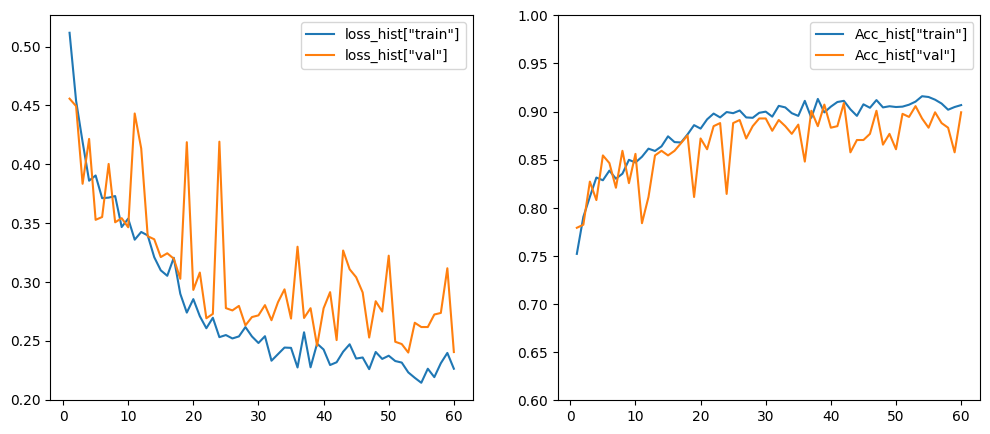

In [56]:
import seaborn as sns

# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

ax[1].set_ylim(0.6,1)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       283
         1.0       0.92      0.87      0.89       342

    accuracy                           0.89       625
   macro avg       0.89      0.89      0.89       625
weighted avg       0.89      0.89      0.89       625
 


